## Initial setup

### labels are Night, Shadow, category

In [1]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [2]:
!nvidia-smi

Sun Jan 30 18:22:22 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 471.41       Driver Version: 471.41       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   41C    P0    26W /  N/A |    148MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# import wandb
# wandb.login()
import os
print(os.getcwd())
model_path='.\\Pretrained_Weights\\'
img_path="C:\\Users\\Sohini Roy\\Documents\\JAAD\\"

C:\Users\Sohini Roy\Documents\JAAD\SimCLR-in-TensorFlow-2-master


In [4]:
# Other imports
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
#from wandb.keras import WandbCallback
import matplotlib.pyplot as plt
from imutils import paths
from tqdm import tqdm
import tensorflow as tf
#import seaborn as sns
import numpy as np
import cv2

# Random seed fixation
tf.random.set_seed(666)
np.random.seed(666)

## Dataset gathering and preparation

In [5]:
import pandas as pd
df=pd.read_csv("C:\\Users\\Sohini Roy\\Documents\\JAAD\\JAAD_train_frames.csv")

In [6]:
df.head()

,Unnamed: 0,seq_no,frame_no,Day,Night,Shadows,Category
0,0,video_0023,00000.png,0,1,0,City
1,1,video_0023,00001.png,0,1,0,City
2,2,video_0023,00002.png,0,1,0,City
3,3,video_0023,00003.png,0,1,0,City
4,4,video_0023,00004.png,0,1,0,City


In [7]:
seq=df["seq_no"]
frame=df["frame_no"]
lab=df["Night"].astype(str)+df["Shadows"].astype(str)+df["Category"]
nf=int(len(seq))

In [8]:
if not os.path.exists('.\\train_ssim\\'):
     os.makedirs('.\\train_ssim\\')

In [9]:
img_path="C:\\Users\\Sohini Roy\\Documents\\JAAD\\images\\"

In [10]:
def prepare_images(image_paths):
    images = []
    

    for image in tqdm(image_paths):
        image_pixels = plt.imread(image)
        image_pixels = cv2.resize(image_pixels, (224, 224))
        image_pixels = image_pixels/255.

        

        images.append(image_pixels)
        

    images = np.array(images)
   
    print(images.shape)

    return images

In [11]:
from shutil import copyfile
train_images=[]
train_labels=[]
 #This is train data
for v in range(len(seq)):
    copyfile(img_path+seq[v]+'\\'+frame[v],'.\\train\\'+seq[v]+frame[v])
    train_images.append('.\\train\\'+seq[v]+frame[v])
    train_labels.append(lab[v])
train_labels=np.array(train_labels)

In [12]:
X_train = prepare_images(train_images)
y_train=train_labels
#X_test, y_test = prepare_images(test_images)

100%|██████████████████████████████████████████████████████████████████████████████| 1431/1431 [01:03<00:00, 22.56it/s]


(1431, 224, 224, 3)


In [13]:
#Now create test data
#We do this later
#--------------------------------------------------------------------------------------------------------
test_images=[]
test_labels=[]

df_test=pd.read_csv("C:\\Users\\Sohini Roy\\Documents\\JAAD\\JAAD_test_frames.csv")
seq_t=df_test["seq_no"]
frame_t=df_test["frame_no"]
lab_t=df_test["Night"].astype(str)+df_test["Shadows"].astype(str)+df_test["Category"]
nt=int(len(seq_t))

for vi in range(nt):
    #copyfile(img_path+seq[vi]+'\\'+frame[vi],'.\\test\\'+seq[vi]+frame[vi])
    test_images.append(img_path+seq_t[vi]+'\\'+frame_t[vi])
    test_labels.append(lab_t[vi])
test_labels=np.array(test_labels)


In [14]:
X_test = prepare_images(test_images)
y_test=test_labels

100%|██████████████████████████████████████████████████████████████████████████████| 4670/4670 [03:37<00:00, 21.49it/s]


(4670, 224, 224, 3)


In [15]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

In [16]:
list(le.inverse_transform([0,1,2,3,4]))

['00City', '00Pedestrians', '01City', '01Pedestrians', '10City']

## Utilities

In [17]:
# Architecture utils
def get_resnet_simclr(hidden_1, hidden_2, hidden_3):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights=None, input_shape=(224, 224, 3))
    base_model.trainable = True
    inputs = Input((224, 224, 3))
    h = base_model(inputs, training=False)
    h = GlobalAveragePooling2D()(h)

    projection_1 = Dense(hidden_1)(h)
    projection_1 = Activation("relu")(projection_1)
    projection_2 = Dense(hidden_2)(projection_1)
    projection_2 = Activation("relu")(projection_2)
    projection_3 = Dense(hidden_3)(projection_2)

    resnet_simclr = Model(inputs, projection_3)

    return resnet_simclr

In [18]:
resnet_simclr = get_resnet_simclr(256, 128,50)
resnet_simclr.load_weights('.\\Pretrained_Weights\\20200508-134915resnet_simclr.h5')
resnet_simclr.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0     

In [19]:
def plot_training(H):
	plt.plot(H.history["loss"], label="train_loss")
	plt.plot(H.history["val_loss"], label="val_loss")
	plt.plot(H.history["accuracy"], label="train_acc")
	plt.plot(H.history["val_accuracy"], label="val_acc")
	plt.title("Training Loss and Accuracy")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss/Accuracy")
	plt.legend(loc="lower left")
	plt.show()

In [20]:
def get_linear_model(features):
    linear_model = Sequential([Dense(5, input_shape=(features, ), activation="softmax")])
    return linear_model

## Evaluation

In [21]:
resnet_simclr.layers[1].trainable = False
resnet_simclr.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0     

In [22]:
# Encoder model with no projection
projection = Model(resnet_simclr.input, resnet_simclr.layers[-6].output)

# Extract train and test features
train_features = projection.predict(X_train)
#test_features = projection.predict(X_test)

print(train_features.shape)#, test_features.shape)

(1431, 2048)


In [23]:
# Early Stopping to prevent overfitting
es = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=5, verbose=2, restore_best_weights=True)

Epoch 1/35
9/9 [==============================] - 0s 15ms/step - loss: 3.7854 - accuracy: 0.4677 - val_loss: 10.2895 - val_accuracy: 0.4808
Epoch 2/35
9/9 [==============================] - 0s 3ms/step - loss: 1.9430 - accuracy: 0.4030 - val_loss: 11.8868 - val_accuracy: 0.4808
Epoch 3/35
9/9 [==============================] - 0s 3ms/step - loss: 1.4701 - accuracy: 0.4913 - val_loss: 12.4900 - val_accuracy: 0.4808
Epoch 4/35
9/9 [==============================] - 0s 3ms/step - loss: 1.2696 - accuracy: 0.5909 - val_loss: 12.9579 - val_accuracy: 0.4808
Epoch 5/35
9/9 [==============================] - 0s 3ms/step - loss: 1.1916 - accuracy: 0.5909 - val_loss: 13.0575 - val_accuracy: 0.4808
Epoch 6/35
9/9 [==============================] - 0s 3ms/step - loss: 1.1174 - accuracy: 0.5909 - val_loss: 13.1339 - val_accuracy: 0.4808
Epoch 7/35
9/9 [==============================] - 0s 3ms/step - loss: 1.1182 - accuracy: 0.5909 - val_loss: 13.1337 - val_accuracy: 0.4808
Epoch 8/35
9/9 [==========

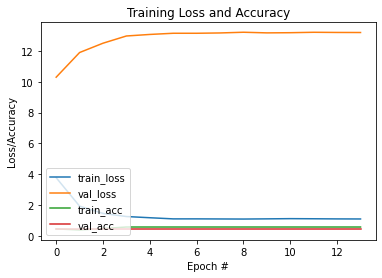

In [24]:
#wandb.init(project="simclr", id="linear-eval-no-projections")

linear_model = get_linear_model(2048)
linear_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")
history = linear_model.fit(train_features, y_train_enc,
                 validation_split=0.2,
                 batch_size=128,
                 epochs=35,
                 callbacks=[es])
plot_training(history)

In [25]:
linear_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 5)                 10245     
Total params: 10,245
Trainable params: 10,245
Non-trainable params: 0
_________________________________________________________________


In [26]:
loss, accuracy = linear_model.evaluate(train_features, y_train_enc, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 3.5354862213134766
Test accuracy: 0.5688329935073853


# Best feature Space is: PCA, or TSNE (perp 100), layers (op, -2, -4, -6)
## Train JAAD on: 0022, 0023, 0286, 0292, 0295, 0303

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', 
                            cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    


In [28]:
# Apply label spreading to figure out best representation space
from sklearn.semi_supervised import LabelSpreading
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

def train_test_data_create(X_train, X_test, la):
    # First generate dimension reduced features for train and test
    projection = Model(resnet_simclr.input, resnet_simclr.layers[-la].output)
    train_features = projection.predict(X_train)
    test_features=projection.predict(X_test)
    #pca = TSNE(perplexity=100)
    #pca.fit(train_features)
    pca=PCA(n_components=5)
    train_data = pca.fit_transform(train_features)
    test_data=pca.fit_transform(test_features)
    return (train_data, test_data)
    

def test_scenes_results(train_data, train_labels, test_data, test_labels):
    
   
    # train and test features have similar dimensions
    #label_prop_model = LabelSpreading(kernel='knn', n_neighbors=2001, gamma=500, alpha=0.1)
    label_prop_model = LabelSpreading(kernel='rbf', gamma=2000, alpha=0.01)
    ul=-1*np.ones(nt)
    
    #################Modify algo here
    #print(train_features.shape, test_features.shape)
    data_X=np.concatenate((train_data,test_data))
    data_Y=np.concatenate((train_labels,ul))
    label_prop_model.fit(data_X, data_Y)
    pred_lb = label_prop_model.predict(data_X)
    n=len(train_labels)
    predl=(pred_lb[n:])
    acc=accuracy_score(test_labels, predl)
    print('Accuracy=', acc)
    pr1, rec1, fscore1, _=precision_recall_fscore_support(test_labels, predl, average='macro')
    print('Macro results=', pr1, rec1, fscore1)
    pr2, rec2, fscore2, _=precision_recall_fscore_support(test_labels, predl, average='weighted')
    print('weighted results=', pr2, rec2, fscore2)
    cm = confusion_matrix(test_labels, predl)
    np.set_printoptions(precision=2)
    print('Confusion matrix')
    print(cm)
    plt.figure()
    plot_confusion_matrix(cm,'01234')
    return(predl)
  

Accuracy= 0.9214132762312633
Macro results= 0.34135751559981364 0.380216720389548 0.3595067019975935
weighted results= 0.8641044407287425 0.9214132762312633 0.8917442886494229
Confusion matrix
[[   0    0   90    0    0]
 [   0    0   54    0    0]
 [   0    0 4111    0   55]
 [   0    0  150    0    0]
 [   0    0   18    0  192]]


C:\Users\Sohini Roy\anaconda3\envs\flow\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sohini Roy\anaconda3\envs\flow\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


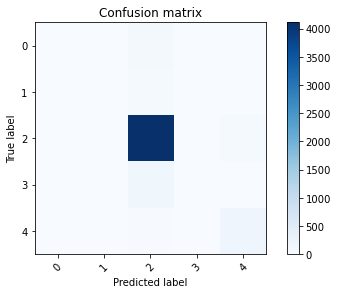

In [29]:
data_train, data_test= train_test_data_create(X_train, X_test, 6)
predl=test_scenes_results(data_train, y_train_enc, data_test, y_test_enc)

Accuracy= 0.9214132762312633
Macro results= 0.34135751559981364 0.380216720389548 0.3595067019975935
weighted results= 0.8641044407287425 0.9214132762312633 0.8917442886494229
Confusion matrix
[[   0    0   90    0    0]
 [   0    0   54    0    0]
 [   0    0 4111    0   55]
 [   0    0  150    0    0]
 [   0    0   18    0  192]]


C:\Users\Sohini Roy\anaconda3\envs\flow\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sohini Roy\anaconda3\envs\flow\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


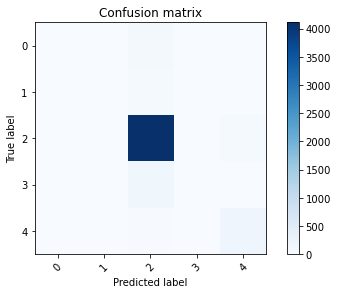

In [30]:
predl=test_scenes_results(data_train, y_train_enc, data_test, y_test_enc)

In [31]:
#def key_frames_detection(train_data, train_labels, test_data):
    
import random   
    # train and test features have similar dimensions
    
ul=-1*np.ones(nt)
    
    #################Modify algo here
    #print(train_features.shape, test_features.shape)
data_X=np.concatenate((data_train,data_test))
data_Y=np.concatenate((y_train_enc,ul))
predl=np.zeros((len(data_test),10))
for i in range(10):
    a=random.uniform(0,1)
    label_prop_model = LabelSpreading(kernel='knn', n_neighbors=581, gamma=int(a*1000), alpha=a)
    label_prop_model.fit(data_X, data_Y)
    pred_lb = label_prop_model.predict(data_X)
    n=len(train_labels)
    predl[:,i]=pred_lb[n:]

# fix gamma at 200 for fewer images

C:\Users\Sohini Roy\anaconda3\envs\flow\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:290: ConvergenceWarning: max_iter=30 was reached without convergence.
  warnings.warn(
C:\Users\Sohini Roy\anaconda3\envs\flow\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:290: ConvergenceWarning: max_iter=30 was reached without convergence.
  warnings.warn(
C:\Users\Sohini Roy\anaconda3\envs\flow\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:290: ConvergenceWarning: max_iter=30 was reached without convergence.
  warnings.warn(
C:\Users\Sohini Roy\anaconda3\envs\flow\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:290: ConvergenceWarning: max_iter=30 was reached without convergence.
  warnings.warn(


In [32]:
# Uncertain samples are ones that have 3 or graeter variants in labels
key_frame=[]
for j in range(nt):
    labl=(len(np.unique(predl[j,:])))
    if labl>1:
        key_frame.append(j)

In [33]:
key_frame=np.array(key_frame)
print(np.shape(key_frame), len(key_frame)/nt)

(328,) 0.0702355460385439


In [34]:
filtered=pd.DataFrame(columns=["index", "seq_no", "frame_no", "Actual Label"])

In [35]:
filtered['seq_no']=seq_t[key_frame]
filtered['frame_no']=frame_t[key_frame]
filtered['Actual Label']=y_test_enc[key_frame]
filtered['index']=key_frame

In [36]:
filtered.head()

,index,seq_no,frame_no,Actual Label
114,114,video_0024,00114.png,4
115,115,video_0024,00115.png,4
116,116,video_0024,00116.png,4
117,117,video_0024,00117.png,4
118,118,video_0024,00118.png,4


In [38]:
filtered.to_csv('simclr_filtering.csv')

In [39]:
nt

4670